In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [38]:
exons = pd.read_csv('../../EVENT_INFO-hg38.tab.gz', sep='\t')[['EVENT', 'COMPLEX', 'CO_C1', 'CO_A', 'CO_C2', 'LE_n']].dropna()

polyA_psi = pd.read_csv('../code/QTLs/QTLTools/polyA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')
chRNA_psi = pd.read_csv('../code/QTLs/QTLTools/chRNA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')

exons = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])]

In [39]:

exon = exons.EVENT
LE = exons.LE_n
c1 = exons.CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1

exon = exons.EVENT
LE = exons.LE_n
c1 = exons.CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1



In [40]:
impact = pd.read_csv('../../PROT_IMPACT-hg38-v3.tab.gz', sep='\t')
impact.index = impact.EventID
# cons = pd.read_csv('../../EVENT_CONSERVATION.tab.gz', sep='\t')

In [41]:
df = pd.DataFrame()
df['event'] = list(exon)
df['chrom'] = list(chrom)
df['donor_c1'] = list(donor_c1)
df['receptor_c1'] = list(receptor_c1)
df['donor_c2'] = list(donor_c2)
df['receptor_c2'] = list(receptor_c2)
df['LE_n'] = list(LE)
df = df.loc[[x[:5]=='HsaEX' for x in df.event]]
df = df.loc[df.event.isin(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].index)]

polyA_psi.end -= 1
chRNA_psi.end -= 1

samples = polyA_psi.columns[6:]

In [42]:
c1 = df.merge(polyA_psi, left_on=['chrom', 'donor_c1', 'receptor_c1'], right_on=['#Chr', 'start', 'end'])
c2 = df.merge(polyA_psi, left_on=['chrom', 'donor_c2', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])
ca = df.merge(polyA_psi, left_on=['chrom', 'donor_c1', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])

c1 = c1.set_index('event').dropna()
c2 = c2.set_index('event').dropna()
ca = ca.set_index('event').dropna()

shared_idx = c1.index.intersection(c2.index.intersection(ca.index))
shared_idx = shared_idx[(c1.loc[shared_idx, samples] - c2.loc[shared_idx, samples]).abs().mean(axis=1) <= 0.333]

psi_c1 = c1.loc[shared_idx, samples]
psi_c2 = c2.loc[shared_idx, samples]
psi_ca = ca.loc[shared_idx, samples]

psi = (psi_c1 + psi_c2)/(psi_c1 + psi_c2 + (2*psi_ca))

In [43]:
c1 = df.merge(chRNA_psi, left_on=['chrom', 'donor_c1', 'receptor_c1'], right_on=['#Chr', 'start', 'end'])
c2 = df.merge(chRNA_psi, left_on=['chrom', 'donor_c2', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])
ca = df.merge(chRNA_psi, left_on=['chrom', 'donor_c1', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])

c1 = c1.set_index('event').dropna()
c2 = c2.set_index('event').dropna()
ca = ca.set_index('event').dropna()

samples = chRNA_psi.columns[6:]

shared_idx = c1.index.intersection(c2.index.intersection(ca.index))
shared_idx = shared_idx[(c1.loc[shared_idx, samples] - c2.loc[shared_idx, samples]).abs().mean(axis=1) <= 0.333]

psi_c1 = c1.loc[shared_idx, samples]
psi_c2 = c2.loc[shared_idx, samples]
psi_ca = ca.loc[shared_idx, samples]

psi_chRNA = (psi_c1 + psi_c2)/(psi_c1 + psi_c2 + (2*psi_ca))



In [8]:
df = df.set_index('event')

polyA_ = [((df.loc[psi.loc[(psi.mean(axis=1) < 0.333) & (psi.mean(axis=1) >= 0.1)].index].LE_n%3)==0).mean(),
    ((df.loc[psi.loc[(psi.mean(axis=1) < 0.667) & (psi.mean(axis=1) >= 0.333)].index].LE_n%3)==0).mean(),
          ((df.loc[psi.loc[(psi.mean(axis=1) >= 0.667) & (psi.mean(axis=1) <= 0.9)].index].LE_n%3)==0).mean()]

Text(0.5, 1.0, 'polyA data')

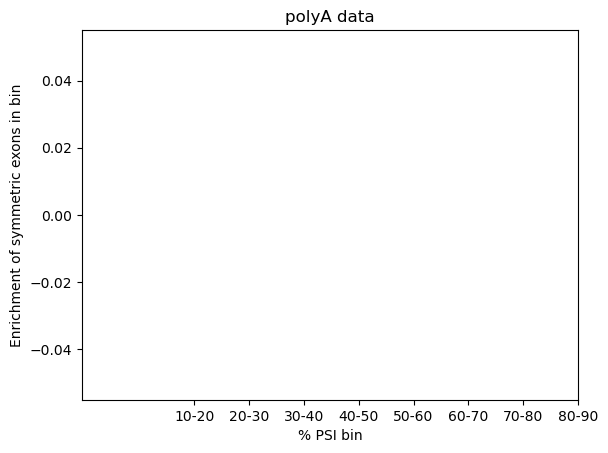

In [9]:
x = np.linspace(0.2, 0.9, 8)
polyA_ = [((df.loc[psi.loc[(psi.mean(axis=1) < i) & (psi.mean(axis=1) >= i- 0.1)].index].LE_n%3)==0).mean() for i in x]
    
plt.bar(x*10, np.array(polyA_))
plt.ylabel('Enrichment of symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(range(2, 10), [str((x-1)*10) + '-' + str(x*10) for x in range(2, 10)])
plt.title('polyA data')

In [10]:
# impact = impact.set_index('EventID')
sorted(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].ONTO.fillna('none').unique())

ORF_distupt = ['ORF disruption upon sequence inclusion', 'ORF disruption upon sequence inclusion (1st CDS intron)',
               'ORF disruption when splice site is used (sequence inclusion)']

NMD_impact = ['ORF disruption upon sequence inclusion (Alt. Stop)']

NMD_excl = ['ORF disruption upon sequence exclusion',
 'ORF disruption upon sequence exclusion (Ref, Alt. ATG (<=10 exons))']

In [11]:
sorted(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].ONTO.fillna('none').unique())
uncertain = ['In the CDS, with uncertain impact']
protein_coding = ['Alternative protein isoforms',
 'Alternative protein isoforms (No Ref)',
 'Alternative protein isoforms (No Ref, Alt. ATG)',
 'Alternative protein isoforms (No Ref, Alt. Stop)',
 'Alternative protein isoforms (Ref)',
 'Alternative protein isoforms (Ref, Alt. ATG (>10 exons))',
 'Alternative protein isoforms (Ref, Alt. Stop)',]

In [12]:
impact_ = []
for idx, row in impact.iterrows():
    i = row.ONTO
    if i in NMD_impact:
        impact_.append('poison exon')
    elif i in NMD_excl:
        impact_.append('NMD upon exclusion')
    elif i in protein_coding:
        impact_.append('alt. protein coding')
    elif i in ORF_distupt:
        impact_.append('poison exon')
    elif i in uncertain:
        impact_.append('uncertain')
    else:
        if idx in psi.index:
            print(i)
        impact_.append('uncertain')
        
impact['impact'] = impact_

In [13]:
psi_chRNA

,NA18486,NA18497,NA18498,NA18499,NA18502,NA18504,NA18505,NA18507,NA18508,NA18510,...,NA19209,NA19210,NA19213,NA19214,NA19225,NA19236,NA19238,NA19239,NA19247,NA19257
event,,,,,,,,,,,,,,,,,,,,,
HsaEX0000758,0.081083,0.161292,0.333333,0.111111,0.045045,0.066667,0.111111,0.000000,0.000000,0.148145,...,0.142857,0.000000,0.000000,0.000000,0.161292,0.098038,0.061729,0.000000,0.000000,0.156250
HsaEX0002049,0.547172,0.423072,0.481481,0.542166,0.426471,0.381817,0.261539,0.146066,0.299365,0.333333,...,0.159239,0.771426,0.241829,0.222223,0.285711,0.336170,0.589040,0.179106,0.269234,0.318183
HsaEX0002122,0.000000,0.017963,0.300000,0.000000,0.111109,0.000000,0.064220,0.000000,0.000000,0.041667,...,0.104166,0.000000,0.066666,0.000000,0.000000,0.000000,0.115789,0.000000,0.000000,0.000000
HsaEX0002288,0.538460,0.384617,0.428560,0.393940,0.384616,0.021277,0.461537,0.294126,0.245611,0.450985,...,0.164837,0.517240,0.513509,0.333325,0.636365,0.285707,0.450001,0.514287,0.409090,0.192311
HsaEX0003278,0.016575,0.022364,0.000000,0.012723,0.012766,0.115441,0.032258,0.022059,0.021818,0.000000,...,0.046392,0.037288,0.049251,0.114753,0.061539,0.026882,0.079889,0.116280,0.019763,0.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HsaEX0057903,0.988764,1.000000,0.985000,0.965048,0.978094,1.000000,0.991837,0.994845,0.975309,0.984496,...,0.970075,0.976945,0.981309,0.986456,0.977443,0.954803,0.968669,0.946524,1.000000,0.978261
HsaEX0042656,0.206892,0.172416,0.180454,0.040000,0.069182,0.386141,0.042734,0.112783,0.043678,0.123456,...,0.079646,0.136364,0.116750,0.193547,0.096045,0.294113,0.124999,0.051383,0.044776,0.098182
HsaEX0071000,0.384613,0.000000,NaN,0.066667,NaN,0.200000,NaN,0.000000,0.555561,1.000000,...,0.333333,1.000000,NaN,0.555556,NaN,0.000000,1.000000,0.000000,NaN,0.428576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:01<00:00, 81.14it/s]


Text(0, 0.5, 'Percent symmetric')

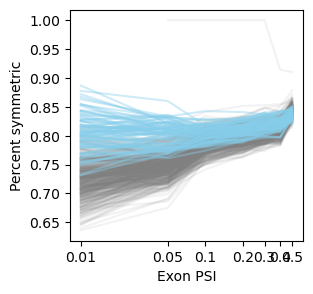

In [70]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

psi_sub = psi.loc[psi.index.intersection(impact.loc[impact.ONTO.isin(protein_coding)].index)]

for s in tqdm(psi_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_sub.loc[(psi_sub[s] <= b1) & (psi_sub[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
psi_chRNA_sub = psi_chRNA.loc[psi_chRNA.index.intersection(impact.loc[impact.ONTO.isin(protein_coding)].index)]
        
for s in tqdm(psi_chRNA_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA_sub.loc[(psi_chRNA_sub[s] <= b1) & (psi_chRNA_sub[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 98.90it/s]


Text(0, 0.5, 'Percent symmetric')

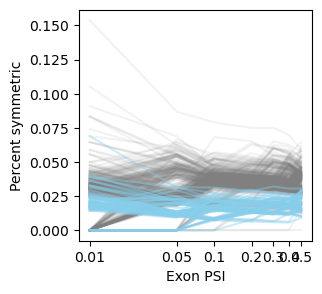

In [69]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

psi_sub = psi.loc[psi.index.intersection(impact.loc[impact.ONTO.isin(uncertain)].index)]

for s in tqdm(psi_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_sub.loc[(psi_sub[s] <= b1) & (psi_sub[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
psi_chRNA_sub = psi_chRNA.loc[psi_chRNA.index.intersection(impact.loc[impact.ONTO.isin(uncertain)].index)]
        
for s in tqdm(psi_chRNA_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA_sub.loc[(psi_chRNA_sub[s] <= b1) & (psi_chRNA_sub[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:01<00:00, 76.08it/s]


Text(0, 0.5, 'Percent symmetric')

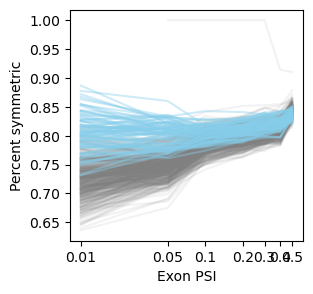

In [77]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

psi_sub = psi.loc[psi.index.intersection(impact.loc[impact.ONTO.isin(protein_coding)].index)]

for s in tqdm(psi_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_sub.loc[(psi_sub[s] <= b1) & (psi_sub[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
psi_chRNA_sub = psi_chRNA.loc[psi_chRNA.index.intersection(impact.loc[impact.ONTO.isin(protein_coding)].index)]
        
for s in tqdm(psi_chRNA_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA_sub.loc[(psi_chRNA_sub[s] <= b1) & (psi_chRNA_sub[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:01<00:00, 60.07it/s]


Text(0, 0.5, 'Percent symmetric')

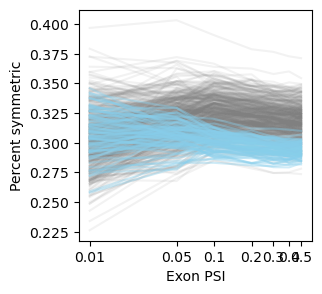

In [59]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

psi_sub = psi.loc[psi.index.intersection(impact.loc[impact.ONTO.isin(NMD_impact)].index)]

for s in tqdm(psi_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_sub.loc[(psi_sub[s] <= b1) & (psi_sub[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
psi_chRNA_sub = psi_chRNA.loc[psi_chRNA.index.intersection(impact.loc[impact.ONTO.isin(NMD_impact)].index)]
        
for s in tqdm(psi_chRNA_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA_sub.loc[(psi_chRNA_sub[s] <= b1) & (psi_chRNA_sub[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 105.06it/s]


Text(0, 0.5, 'Percent symmetric')

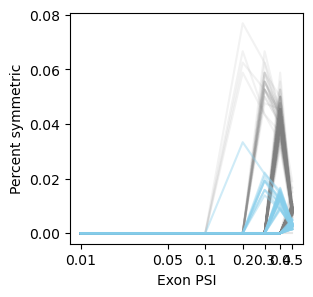

In [60]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

psi_sub = psi.loc[psi.index.intersection(impact.loc[impact.ONTO.isin(NMD_excl)].index)]

for s in tqdm(psi_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_sub.loc[(psi_sub[s] <= b1) & (psi_sub[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
psi_chRNA_sub = psi_chRNA.loc[psi_chRNA.index.intersection(impact.loc[impact.ONTO.isin(NMD_excl)].index)]
        
for s in tqdm(psi_chRNA_sub.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA_sub.loc[(psi_chRNA_sub[s] <= b1) & (psi_chRNA_sub[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

In [80]:
# top_genes = NMD_by_gene.loc[
#     (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

# df = pd.concat([get_slice(top_genes, i, 0.2) for i in np.linspace(0.2, 1, 5)], axis=0)
# df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'green', 'red', 'purple'])
# plt.title(r'Top 25% RPKM genes')

In [60]:
def get_fraction(psi, impact, i0, i1):
    
    impact_slice = impact.loc[psi.loc[(psi.mean(axis=1)<=i1) & (psi.mean(axis=1)>=i0)].index]
    
    n = impact_slice.shape[0]
    
    impact_values = pd.DataFrame(impact_slice.impact.value_counts()/n).T
    
    idx = '[' + str(i0) + ', ' + str(i1) + ']'
    
    impact_values.index = [idx]
    
    return impact_values
    
    
    
[1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]

[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]

In [39]:
impact.ONTO.unique()

array(['ORF disruption upon sequence inclusion',
       'In the CDS, with uncertain impact',
       'Alternative protein isoforms (No Ref)',
       'Alternative protein isoforms (No Ref, Alt. Stop)',
       'Alternative protein isoforms (No Ref, Alt. ATG)',
       'ORF disruption upon sequence exclusion', nan,
       'Alternative protein isoforms (Ref)',
       'Alternative protein isoforms (Ref, Alt. Stop)',
       'ORF disruption upon sequence exclusion (Ref, Alt. ATG (<=10 exons))',
       'Alternative protein isoforms (Ref, Alt. ATG (>10 exons))',
       'ORF disruption upon sequence inclusion (Alt. Stop)'], dtype=object)

In [15]:
exons = exons.set_index('EVENT')

In [16]:
impact.index.intersection(exons.index).intersection(psi.index)

Index(['HsaEX0003278', 'HsaEX0004973', 'HsaEX0005128', 'HsaEX0006939',
       'HsaEX0007810', 'HsaEX0008277', 'HsaEX0011328', 'HsaEX0011583',
       'HsaEX0013779', 'HsaEX0015619',
       ...
       'HsaEX0051561', 'HsaEX0038599', 'HsaEX0066664', 'HsaEX0057202',
       'HsaEX0066721', 'HsaEX0068685', 'HsaEX0005467', 'HsaEX0042343',
       'HsaEX0051392', 'HsaEX0040386'],
      dtype='object', length=3784)

In [52]:
impact = impact.loc[impact.index.intersection(exons.index).intersection(psi.index.union(psi_chRNA.index))]

In [53]:
impact['LE_n'] = exons.loc[impact.index].LE_n

In [85]:
df = pd.concat([get_fraction(psi, impact, 1e-2, 0.05),
                get_fraction(psi, impact, 0.05, 0.1),
                get_fraction(psi, impact, 0.1, 0.2),
                get_fraction(psi, impact, 0.2, 0.3),
                get_fraction(psi, impact, 0.3, 0.4),
                get_fraction(psi, impact, 0.4, 0.5),
                get_fraction(psi, impact, 0.5, 0.6),
                get_fraction(psi, impact, 0.6, 0.7),
                get_fraction(psi, impact, 0.7, 0.8),
                get_fraction(psi, impact, 0.8, 0.9),
                get_fraction(psi, impact, 0.9, 0.99),
                get_fraction(psi, impact, 0.99, 1)
               ])

df = df.reset_index()
df_chRNA = pd.concat([get_fraction(psi_chRNA, impact, 1e-2, 0.05),
                get_fraction(psi_chRNA, impact, 0.05, 0.1),
                get_fraction(psi_chRNA, impact, 0.1, 0.2),
                get_fraction(psi_chRNA, impact, 0.2, 0.3),
                get_fraction(psi_chRNA, impact, 0.3, 0.4),
                get_fraction(psi_chRNA, impact, 0.4, 0.5),
                get_fraction(psi_chRNA, impact, 0.5, 0.6),
                get_fraction(psi_chRNA, impact, 0.6, 0.7),
                get_fraction(psi_chRNA, impact, 0.7, 0.8),
                get_fraction(psi_chRNA, impact, 0.8, 0.9),
                get_fraction(psi_chRNA, impact, 0.9, 0.99),
                      get_fraction(psi_chRNA, impact, 0.99, 1)
               ])

df_chRNA = df_chRNA.reset_index()




# df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'red', 'green', 'purple'])
# plt.title('all genes')

In [86]:
df = pd.concat([df, df_chRNA], axis=0)
df['assay'] = (['polyA']*12) + (['chRNA']*12)
df.reset_index()

,level_0,index,poison exon,alt. protein coding,uncertain,NMD upon exclusion,assay
0,0,"[0.01, 0.05]",0.614833,0.255981,0.107656,0.021531,polyA
1,1,"[0.05, 0.1]",0.537190,0.289256,0.148760,0.024793,polyA
2,2,"[0.1, 0.2]",0.371134,0.505155,0.113402,0.010309,polyA
3,3,"[0.2, 0.3]",0.346939,0.551020,0.061224,0.040816,polyA
4,4,"[0.3, 0.4]",0.193548,0.677419,0.032258,0.096774,polyA
5,5,"[0.4, 0.5]",0.068966,0.517241,0.172414,0.241379,polyA
6,6,"[0.5, 0.6]",0.057143,0.771429,0.085714,0.085714,polyA
7,7,"[0.6, 0.7]",0.097561,0.536585,0.097561,0.268293,polyA
8,8,"[0.7, 0.8]",0.063492,0.650794,0.031746,0.253968,polyA
9,9,"[0.8, 0.9]",NaN,0.615385,0.048951,0.335664,polyA


In [93]:
impact.impact.unique()

array(['poison exon', 'uncertain', 'alt. protein coding',
       'NMD upon exclusion'], dtype=object)

In [87]:
df.index = df.assay + ' ' + df['index']

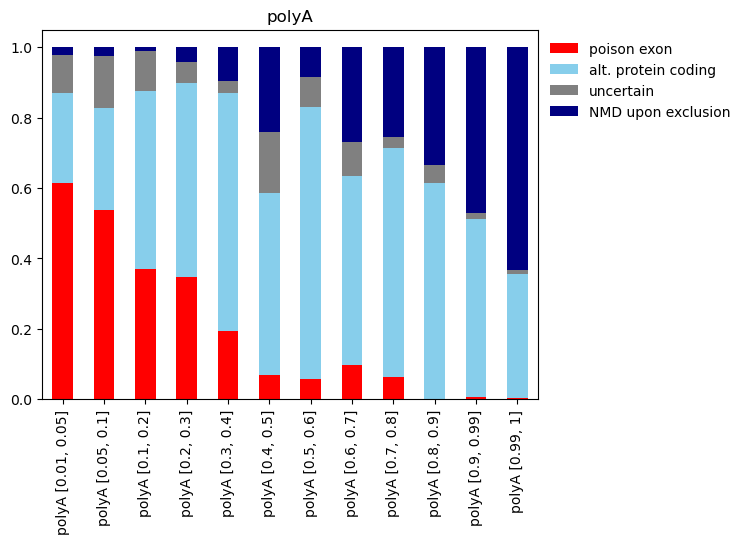

In [88]:
df.loc[df.assay=='polyA'].plot(kind='bar', stacked=True, color=['red', 'skyblue', 'grey', 'navy', 'purple'])
plt.title('polyA')
plt.legend(bbox_to_anchor=(1, 1), frameon=False)

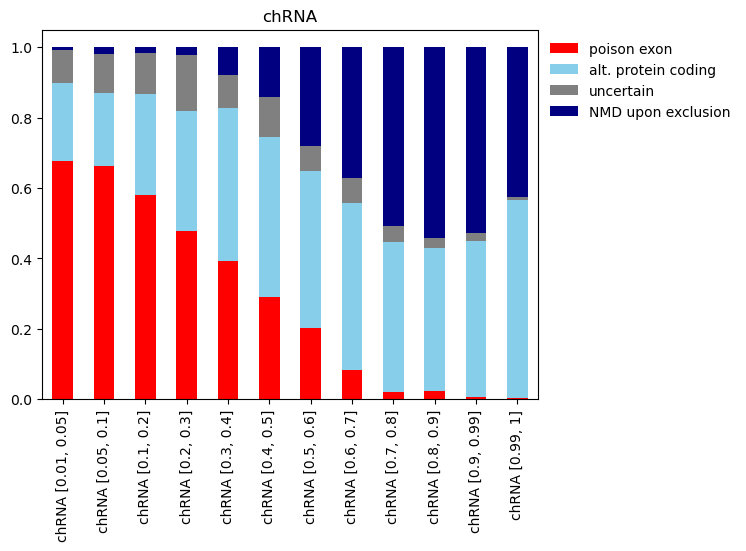

In [89]:
df.loc[df.assay=='chRNA'].plot(kind='bar', stacked=True, color=['red', 'skyblue', 'grey', 'navy', 'purple'])
plt.title('chRNA')
plt.legend(bbox_to_anchor=(1, 1), frameon=False)

(array([  4.,   5.,   5.,   3.,   3.,   1.,   2.,   2.,   1.,   0.,   0.,
          0.,   1.,   2.,   3.,   3.,   4.,   1.,   1.,   3.,   3.,   4.,
          4.,   3.,   3.,   6.,   9.,  16.,   8.,   4.,   5.,  11.,  25.,
         10.,  20.,  17.,  25.,  16.,  28.,  35.,  32.,  51.,  82.,  70.,
        114., 154., 236., 340., 588., 737.]),
 array([0.00449415, 0.02440427, 0.04431438, 0.0642245 , 0.08413462,
        0.10404473, 0.12395485, 0.14386497, 0.16377509, 0.1836852 ,
        0.20359532, 0.22350544, 0.24341555, 0.26332567, 0.28323579,
        0.3031459 , 0.32305602, 0.34296614, 0.36287626, 0.38278637,
        0.40269649, 0.42260661, 0.44251672, 0.46242684, 0.48233696,
        0.50224707, 0.52215719, 0.54206731, 0.56197743, 0.58188754,
        0.60179766, 0.62170778, 0.64161789, 0.66152801, 0.68143813,
        0.70134824, 0.72125836, 0.74116848, 0.7610786 , 0.78098871,
        0.80089883, 0.82080895, 0.84071906, 0.86062918, 0.8805393 ,
        0.90044941, 0.92035953, 0.94026965, 0.

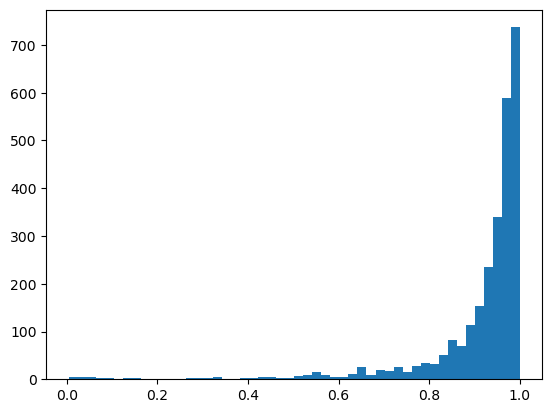

In [98]:
plt.hist(psi_chRNA.loc[impact.loc[impact.impact == 'NMD upon exclusion'].index.intersection(psi_chRNA.index)].mean(axis=1), 
         bins=50)

In [118]:
essential_chRNA_psi = psi_chRNA.loc[impact.loc[impact.impact == 'NMD upon exclusion'
                                              ].index.intersection(psi_chRNA.index)].mean(axis=1)

essential_polyA_psi = psi.loc[impact.loc[impact.impact == 'NMD upon exclusion'
                                              ].index.intersection(psi.index)].mean(axis=1)


poison_chRNA_psi = psi_chRNA.loc[impact.loc[impact.impact == 'poison exon'
                                              ].index.intersection(psi_chRNA.index)].mean(axis=1)

poison_polyA_psi = psi.loc[impact.loc[impact.impact == 'poison exon'
                                              ].index.intersection(psi.index)].mean(axis=1)
# essential_chRNA = [psi.loc[psi.PSI <= y].Count.sum() for y in x]

# contribution_PC = [long_table_sum_PC.loc[long_table_sum_PC.PSI <= y].Count.sum() for y in x]



Text(0.5, 1.0, 'Poison exon')

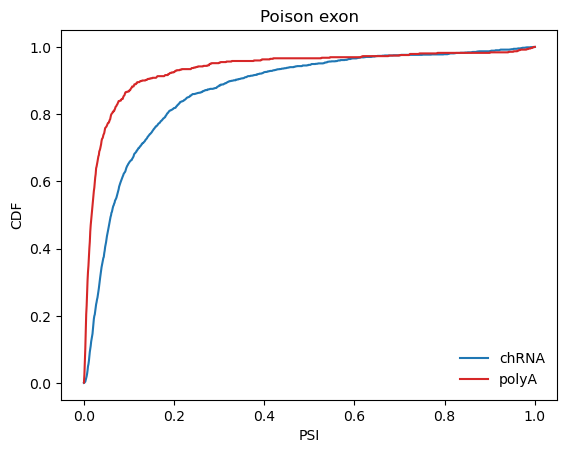

In [120]:
x = np.linspace(0, 1, 1001)
plt.plot(x, [(poison_chRNA_psi <= i).mean() for i in x], c='tab:blue', label='chRNA')
plt.plot(x, [(poison_polyA_psi <= i).mean() for i in x], c='tab:red', label='polyA')
plt.legend(frameon=False)
plt.xlabel('PSI')
plt.ylabel('CDF')
plt.title('Poison exon')

Text(0.5, 1.0, 'NMD upon exclusion')

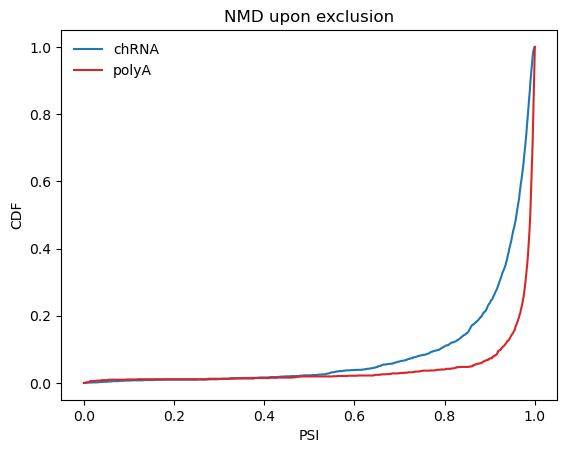

In [113]:
plt.plot(x, [(essential_chRNA_psi <= i).mean() for i in x], c='tab:blue', label='chRNA')
plt.plot(x, [(essential_polyA_psi <= i).mean() for i in x], c='tab:red', label='polyA')
plt.legend(frameon=False)
plt.xlabel('PSI')
plt.ylabel('CDF')
plt.title('NMD upon exclusion')

In [116]:
impact.impact.unique()

array(['poison exon', 'uncertain', 'alt. protein coding',
       'NMD upon exclusion'], dtype=object)

Text(0, 0.5, 'Percent symmetric')

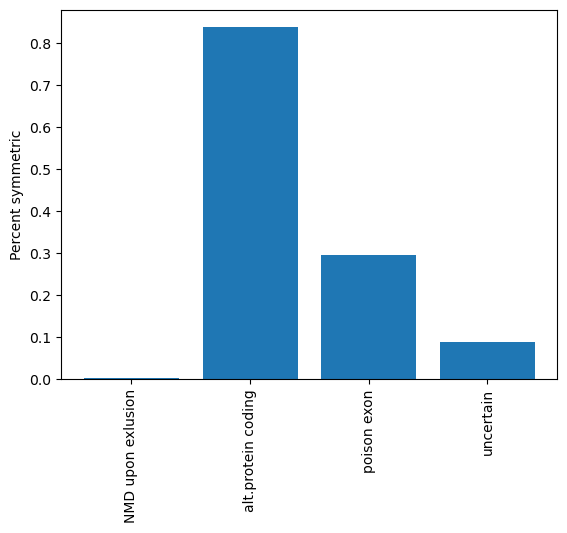

In [73]:
plt.bar([0, 1, 2, 3], impact.groupby('impact').symmetric.mean())
plt.xticks([0, 1, 2, 3], ['NMD upon exlusion', 'alt.protein coding', 'poison exon', 'uncertain'], rotation=90)
plt.ylabel('Percent symmetric')

Text(0.5, 1.0, 'all genes')

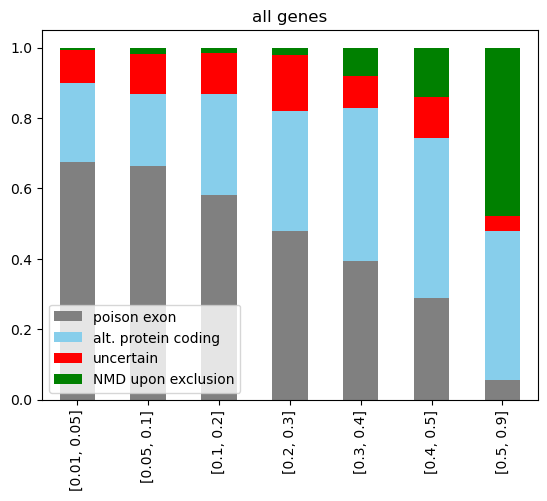

In [114]:
df = pd.concat([get_fraction(psi_chRNA, impact, 1e-2, 0.05),
                get_fraction(psi_chRNA, impact, 0.05, 0.1),
                get_fraction(psi_chRNA, impact, 0.1, 0.2),
                get_fraction(psi_chRNA, impact, 0.2, 0.3),
                get_fraction(psi_chRNA, impact, 0.3, 0.4),
                get_fraction(psi_chRNA, impact, 0.4, 0.5),
                get_fraction(psi_chRNA, impact, 0.5, 0.9),
               ])

df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'red', 'green', 'purple'])
plt.title('all genes')

In [86]:
impact.loc[psi_chRNA.loc[psi_chRNA['NA18486']<0.1].index].impact.value_counts()/impact.loc[psi_chRNA.loc[psi_chRNA['NA18486']<0.1].index].shape[0]

poison exon            0.648553
alt. protein coding    0.236858
uncertain              0.092144
NMD upon exclusion     0.012404
none                   0.010041
Name: impact, dtype: float64

<Axes: xlabel='count', ylabel='ONTO'>

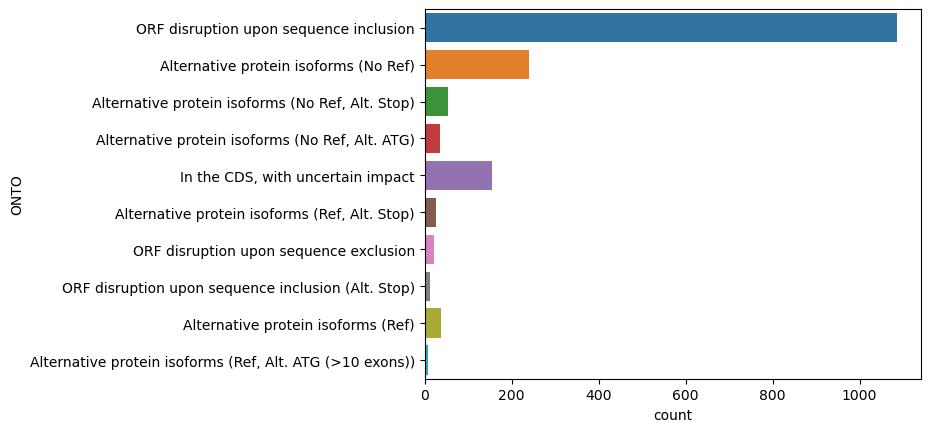

In [58]:
sns.countplot(data = impact.loc[psi_chRNA.loc[psi_chRNA['NA18486']<0.1].index], y='ONTO')

Index([], dtype='object')

<Axes: xlabel='count', ylabel='ONTO'>

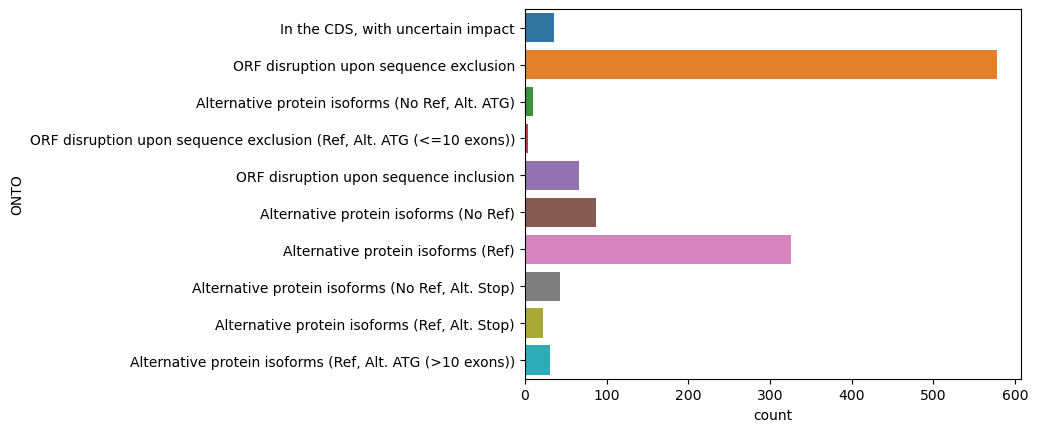

In [75]:
sns.countplot(data = impact.loc[(psi_chRNA.loc[psi_chRNA.mean(axis=1)>0.5].index).intersection(psi_chRNA.loc[psi_chRNA.mean(axis=1)<0.9].index)], y='ONTO')

<Axes: xlabel='count', ylabel='ONTO'>

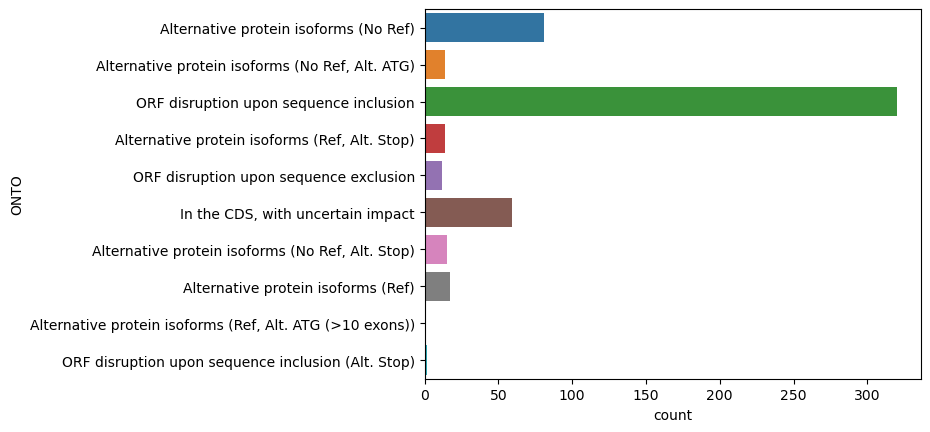

In [56]:
sns.countplot(data = impact.loc[(psi.loc[psi.mean(axis=1)>0.01].index).intersection(psi.loc[psi.mean(axis=1)<0.1].index)], y='ONTO')

<Axes: xlabel='count', ylabel='ONTO'>

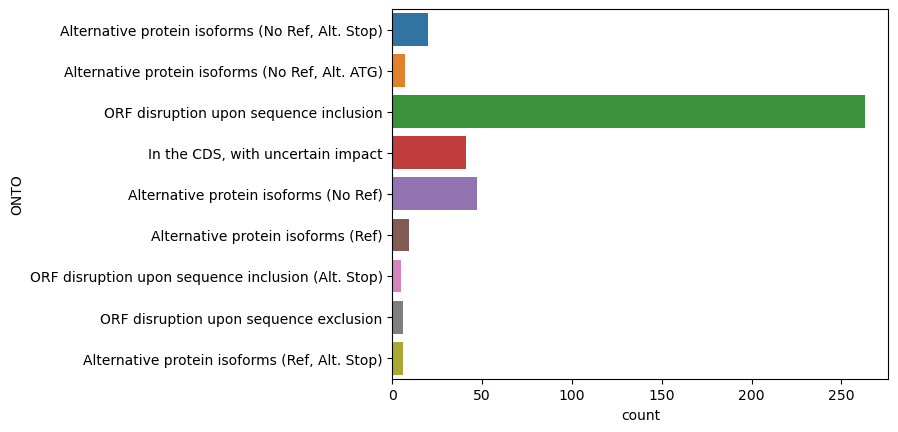

In [44]:
sns.countplot(data = impact.loc[psi.loc[psi['HG00096']<0.01].index], y='ONTO')

In [50]:
df = df.set_index('event')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:01<00:00, 69.93it/s]


Text(0, 0.5, 'Percent symmetric')

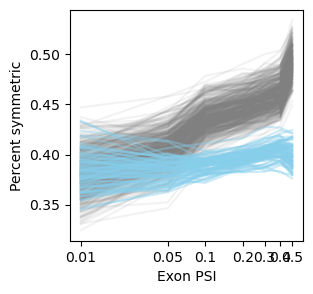

In [54]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

# shr = psi.index.intersection


for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:03<00:00, 24.66it/s]


Text(0, 0.5, 'Percent symmetric')

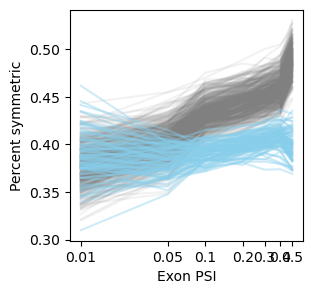

In [52]:
shared_idx = psi.index.intersection(psi_chRNA.index)

fig, ax = plt.subplots(figsize=(3, 3))



for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi.loc[shared_idx].loc[(psi.loc[shared_idx][s] <= b1) & (psi.loc[shared_idx][s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA.loc[shared_idx].loc[(psi_chRNA.loc[shared_idx][s] <= b1) & (psi_chRNA.loc[shared_idx][s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

<Axes: xlabel='count', ylabel='ONTO'>

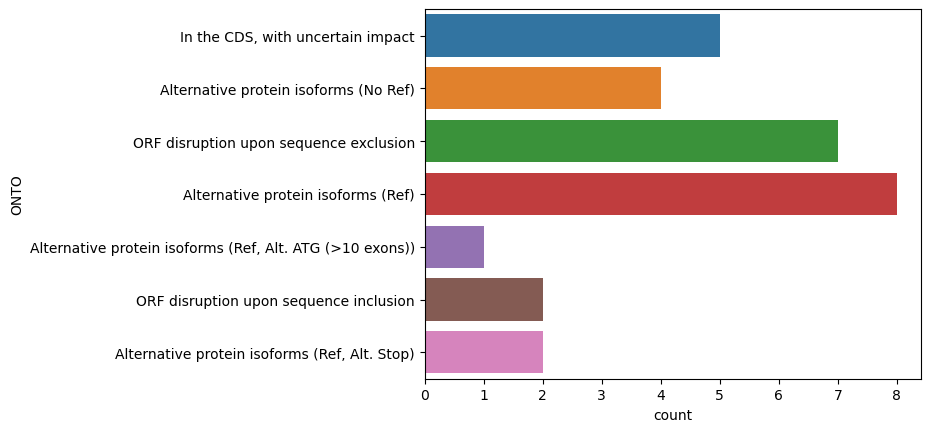

In [76]:
sns.countplot(data = impact.loc[(psi.loc[psi.mean(axis=1)>0.4].index).intersection(psi.loc[psi.mean(axis=1)<0.5].index)], y='ONTO')

<Axes: xlabel='count', ylabel='ONTO'>

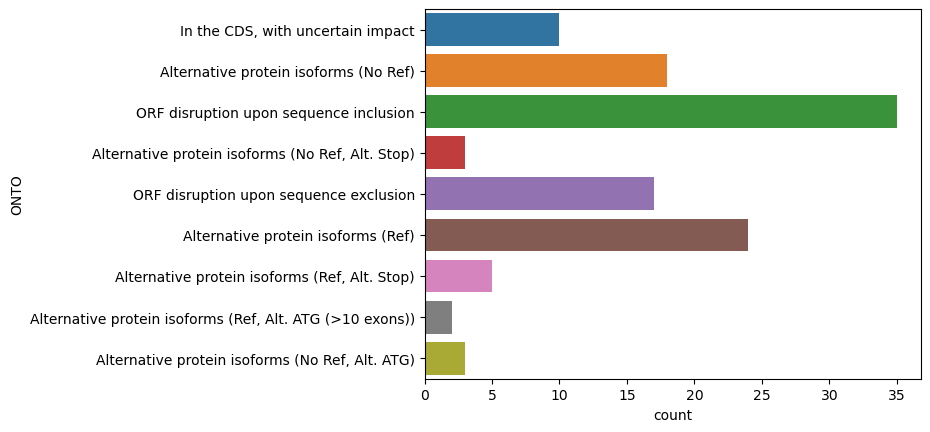

In [74]:
sns.countplot(data = impact.loc[(psi_chRNA.loc[psi_chRNA.mean(axis=1)>0.4].index).intersection(psi_chRNA.loc[psi_chRNA.mean(axis=1)<0.5].index)], y='ONTO')

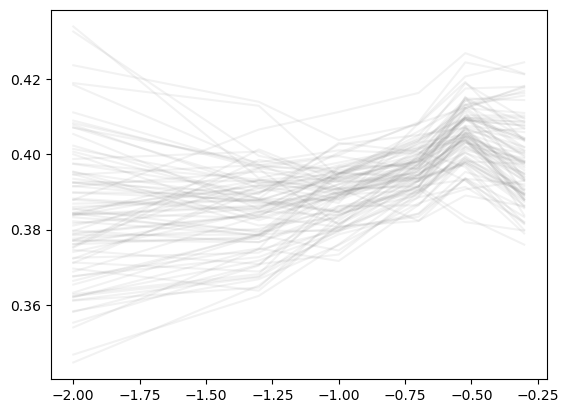

In [45]:
for s in psi_chRNA.columns:
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    plt.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        

In [42]:
bins = [1e-3, 1e-2, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9]
for i in range(1, len(bins)):
    b1 = bins[i]
    b0 = bins[0]
    print(((df.loc[psi_chRNA.loc[(psi_chRNA.mean(axis=1) <= b1) & (psi_chRNA.mean(axis=1) > b0)].index].LE_n%3)==0).mean())

0.40425531914893614
0.3831231813773036
0.38140417457305503
0.3873031496062992
0.38662533215234723
0.3977183320220299
0.39138526987503325


In [10]:
polyA_ = [((df.loc[psi.loc[(psi.mean(axis=1) < 0.333) & (psi.mean(axis=1) >= 0.1)].index].LE_n%3)==0).mean(),
    ((df.loc[psi.loc[(psi.mean(axis=1) < 0.667) & (psi.mean(axis=1) >= 0.333)].index].LE_n%3)==0).mean(),
          ((df.loc[psi.loc[(psi.mean(axis=1) >= 0.667) & (psi.mean(axis=1) <= 0.9)].index].LE_n%3)==0).mean()]

In [10]:
((df.loc[psi.loc[(psi.mean(axis=1) < 1e-3)].index].LE_n%3)==0).mean()

0.47368421052631576

In [18]:
((df.loc[psi.loc[(psi.mean(axis=1) >= 1e-2) & (psi.mean(axis=1) < 1e-1)].index].LE_n%3)==0).mean()

0.3914656771799629

In [15]:
((df.loc[psi_chRNA.loc[(psi_chRNA.mean(axis=1) < 1e-2)].index].LE_n%3)==0).mean()

0.3958333333333333

In [17]:
((df.loc[psi.loc[(psi_chRNA.mean(axis=1) >= 1e-2) & (psi_chRNA.mean(axis=1) < 1e-1)].index].LE_n%3)==0).mean()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])


In [2]:
long_table_chRNA = long_table.loc[long_table.Dataset=='chRNA.Expression.Splicing']
long_table_polyA = long_table.loc[long_table.Dataset=='Expression.Splicing']

del long_table
del intron_annot

In [12]:
(((long_table_polyA.stop-long_table_polyA.start)%3)==2).mean()

0.3330255331925972

In [3]:
ltp = long_table_polyA.groupby(['junction', 'gene', 'start', 'end']).Count.sum().reset_index()

In [11]:
ltp_gene = pd.DataFrame(ltp.groupby('gene').Count.max())
ltp_gene.columns=['max_counts']

In [13]:
ltp = ltp.merge(ltp_gene, left_on='gene', right_index=True)
ltp['PSI'] = ltp.Count/ltp.max_counts

In [51]:
(((ltp.loc[(ltp.PSI < 0.9) & (ltp.PSI > 0.8)].end - ltp.loc[(ltp.PSI < 0.9) & (ltp.PSI > 0.8)].start)%3)==2).mean()

0.337326419929674

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

chRNA_psi = pd.read_csv('../code/QTLs/QTLTools/chRNA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')
polyA_psi = pd.read_csv('../code/QTLs/QTLTools/polyA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')

In [51]:
chRNA_samples = chRNA_psi.columns[6:]
polyA_samples = polyA_psi.columns[6:]

In [52]:
polyA_mean_psi = polyA_psi[polyA_samples].fillna(0).mean(axis=1)
chRNA_mean_psi = chRNA_psi[chRNA_samples].fillna(0).mean(axis=1)

polyA_mean_psi = pd.DataFrame(polyA_mean_psi)
polyA_mean_psi.columns = ['PSI']

chRNA_mean_psi = pd.DataFrame(chRNA_mean_psi)
chRNA_mean_psi.columns = ['PSI']

In [53]:
polyA = polyA_psi[polyA_psi.columns[:6]].merge(polyA_mean_psi, left_index=True, right_index = True)

In [54]:
(((polyA.loc[(polyA.PSI > 1e-1) & polyA.PSI < 0.9].end - polyA.loc[(polyA.PSI > 1e-1) & polyA.PSI < 0.9].start) %3) == 2
).mean()

0.33032466333143284

In [50]:
(((polyA_psi.loc[polyA_psi['HG00096'] < 1e-1].end - polyA_psi.loc[polyA_psi['HG00096'] < 1e-1].start)%3)==1).mean()

0.3344704575137917

In [62]:
polyA_psi_ = polyA_psi.loc[polyA_psi[polyA_samples].isna().mean(axis=1) < 0.1].fillna(0)

In [77]:
(((polyA_psi_.loc[
    (polyA_psi_[polyA_samples].mean(axis=1) > 0.5) & (polyA_psi_[polyA_samples].mean(axis=1) < 0.9)].end - polyA_psi_.loc[
    (polyA_psi_[polyA_samples].mean(axis=1) > 0.5) & (polyA_psi_[polyA_samples].mean(axis=1) < 0.9)].start)%3)==0).mean()

0.3351481683129813

 34%|███████████████████████████████████████████████████▋                                                                                                    | 157/462 [03:07<06:05,  1.20s/it]


KeyboardInterrupt: 

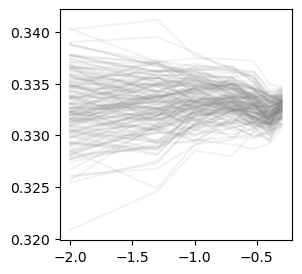

In [81]:
fig, ax = plt.subplots(figsize=(3, 3))

for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(
            (((polyA_psi_.loc[
    (polyA_psi_[s] > b0) & (polyA_psi_[s] < b1)].end - polyA_psi_.loc[
    (polyA_psi_[s] > b0) & (polyA_psi_[s] < b1)].start)%3)==0).mean()
        
        )
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)

In [91]:
psi

,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00105,HG00106,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
event,,,,,,,,,,,,,,,,,,,,,
HsaEX0003278,0.087718,0.033708,0.000000,0.000000,0.010989,0.000000,0.076923,0.083332,0.000000,0.034965,...,0.031915,0.047619,0.019608,0.127272,0.049646,0.000000,0.064935,0.058824,0.018182,0.027397
HsaEX0004973,0.000000,0.009901,0.034483,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,0.021739,...,0.000000,0.000000,0.000000,0.018182,0.024000,0.008547,0.000000,0.000000,0.000000,0.008547
HsaEX0005128,0.000000,0.028446,0.066667,0.005347,0.017752,0.056604,0.074999,0.068965,0.026217,0.042553,...,0.024390,0.014778,0.018277,0.043824,0.077669,0.052356,0.043165,0.040650,0.053334,0.016949
HsaEX0006939,0.911765,0.885056,1.000000,0.921567,0.672728,0.954546,1.000000,0.872341,0.980392,0.870130,...,0.749995,1.000000,0.868853,0.942857,0.729725,0.723413,0.962964,0.942857,0.955555,0.892307
HsaEX0007810,0.040000,0.090909,0.054945,0.017544,0.035714,0.000000,0.152541,0.022222,0.041667,0.053764,...,0.041667,0.116279,0.051282,0.045871,0.016667,0.045454,0.000000,0.058824,0.038961,0.100001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HsaEX0068685,0.181286,0.178377,0.192981,0.147829,0.245282,0.349998,0.178077,0.168827,0.186945,0.142855,...,0.208162,0.210192,0.135341,0.211268,0.252521,0.163000,0.151166,0.191175,0.282053,0.127072
HsaEX0005467,0.040001,0.000000,0.000000,0.000000,0.142857,0.230772,0.000000,0.040000,0.012049,0.000000,...,0.000000,0.000000,0.051283,0.103449,0.000000,0.041667,0.022223,0.052631,0.019608,0.073169
HsaEX0042343,0.384610,0.417726,0.404959,0.367815,0.463412,0.309091,0.355551,0.357146,0.371426,0.244898,...,0.294690,0.426571,0.366196,0.254125,0.365638,0.315252,0.251396,0.394355,0.482356,0.219998


Text(0, 0.5, 'Percent symmetric')

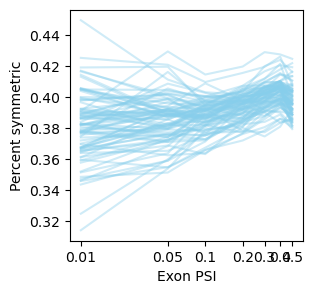

In [125]:
fig, ax = plt.subplots(figsize=(3, 3))

psi_diff = psi_chRNA.loc[psi_chRNA.index.difference(psi.index)]

for s in psi_diff.columns:
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_diff.loc[(psi_diff[s] <= b1) & (psi_diff[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

In [84]:
psi_chRNA.loc[psi_chRNA.index.difference(psi.index)]

,NA18486,NA18497,NA18498,NA18499,NA18502,NA18504,NA18505,NA18507,NA18508,NA18510,...,NA19209,NA19210,NA19213,NA19214,NA19225,NA19236,NA19238,NA19239,NA19247,NA19257
event,,,,,,,,,,,,,,,,,,,,,
HsaEX0000029,1.000000,0.230769,0.090911,0.000000,0.000000,0.599993,0.241380,0.562502,0.166669,0.000000,...,0.312500,0.153847,0.250000,0.333333,0.000000,0.488373,0.272726,0.263156,0.142857,0.173913
HsaEX0000117,0.893939,0.747748,0.894737,0.912280,0.969696,0.941176,0.980582,0.846155,0.902913,0.967743,...,0.694915,0.958762,0.971222,0.867299,0.768114,1.000000,1.000000,0.972029,0.858587,0.939394
HsaEX0000308,1.000000,1.000000,0.983193,0.949580,1.000000,1.000000,1.000000,1.000000,0.873015,0.949367,...,1.000000,0.920000,1.000000,0.959732,1.000000,0.961538,0.943926,0.950001,1.000000,0.978022
HsaEX0000309,0.968587,1.000000,0.985714,1.000000,0.972509,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.977400,0.950820,1.000000,1.000000,0.968086,1.000000,1.000000
HsaEX0000310,0.700938,0.779409,0.759400,0.874015,0.782388,0.932203,0.749996,0.833333,0.907692,0.834587,...,0.888887,0.826088,0.771811,0.874127,0.952942,0.837399,0.898796,0.815607,0.954024,0.754909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HsaEX7107473,0.950412,1.000000,0.883494,0.957896,1.000000,1.000000,1.000000,0.973332,0.938462,0.950000,...,0.824560,1.000000,1.000000,0.944445,1.000000,1.000000,0.978261,1.000000,1.000000,1.000000
HsaEX7107479,0.807693,0.813952,0.964911,0.975610,0.863015,1.000000,1.000000,0.884057,0.844828,0.853657,...,1.000000,0.966386,0.968750,0.960397,0.955554,0.952381,0.931036,0.982143,1.000000,1.000000
HsaEX7107480,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(array([  13.,   33.,  116.,  980., 2085.,  204.,   67.,   16.,   11.,
           3.]),
 array([-0.45925152, -0.34940051, -0.2395495 , -0.12969849, -0.01984749,
         0.09000352,  0.19985453,  0.30970554,  0.41955655,  0.52940756,
         0.63925857]),
 <BarContainer object of 10 artists>)

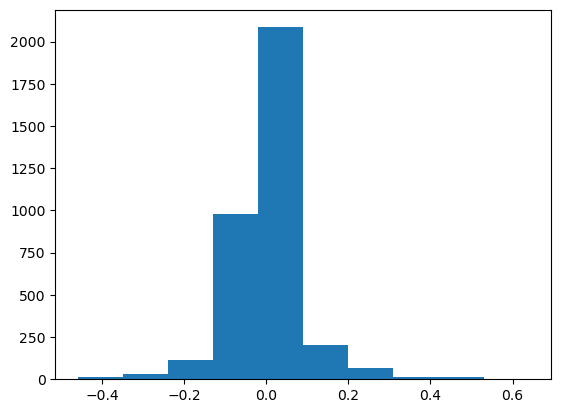

In [118]:
shared_idx = psi.index.intersection(psi_chRNA.index)
plt.hist(psi_chRNA.loc[shared_idx].fillna(0).mean(axis=1) - psi.loc[shared_idx].fillna(0).mean(axis=1))

In [119]:
psi_diff = psi_chRNA.loc[shared_idx].fillna(0).mean(axis=1) - psi.loc[shared_idx].fillna(0).mean(axis=1)

In [122]:
((df.loc[psi_diff.loc[(psi_diff <= -0.2) & (psi_diff > -1)].index].LE_n%3)==1).mean()

0.5

In [147]:
psi_dif = psi_chRNA.loc[shared_idx, 'NA18486'] - psi.loc[shared_idx, 'NA18486']

In [144]:
df.loc[shared_idx]#psi_dif

,chrom,donor_c1,receptor_c1,donor_c2,receptor_c2,LE_n
event,,,,,,
HsaEX0003278,chr2,61185618,61185838,61185865,61186445,27
HsaEX0004973,chr8,42167810,42168196,42168249,42168960,53
HsaEX0005128,chr11,43312196,43318420,43318482,43318639,62
HsaEX0006939,chr14,50322719,50323944,50324116,50325608,172
HsaEX0007810,chr7,107613432,107616260,107616389,107618327,129
...,...,...,...,...,...,...
HsaEX0068685,chr1,154268954,154269361,154269412,154270199,51
HsaEX0005467,chr5,143207308,143207443,143207473,143213996,30
HsaEX0042343,chr21,42897047,42903181,42904276,42908863,1095


(array([   2.,    3.,    9.,  104., 1531., 1765.,   74.,   17.,    6.,
           5.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

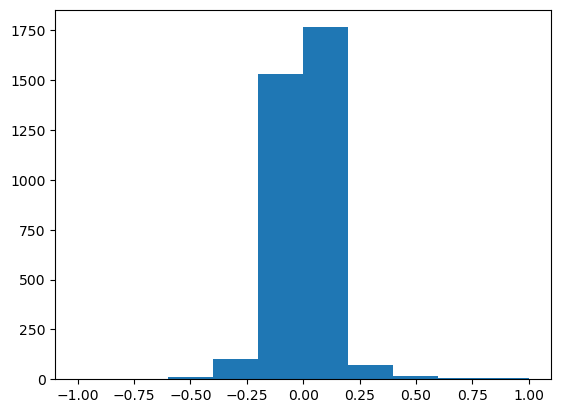

In [148]:
plt.hist(psi_dif)

In [155]:
((df.loc[psi_dif.loc[(psi_dif <= psi_dif.quantile(0.3)) & (psi_dif > psi_dif.quantile(0.2))].index].LE_n%3)==0).mean()

0.3817663817663818

In [153]:
df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3 ==0

0.032026584307363534

In [168]:
shared_idx[(psi_chRNA.loc[shared_idx, 'NA18486'] <= 0.9) & (psi_chRNA.loc[shared_idx, 'NA18486'] >= 0.1) & ]

Index(['HsaEX0027135', 'HsaEX0019289', 'HsaEX0016170', 'HsaEX0026567',
       'HsaEX1031578', 'HsaEX0049928', 'HsaEX0030574', 'HsaEX0045927',
       'HsaEX0029505', 'HsaEX0035067', 'HsaEX0023158', 'HsaEX0069934',
       'HsaEX0056687', 'HsaEX6068932', 'HsaEX0009134', 'HsaEX0023542',
       'HsaEX0059568', 'HsaEX0019778', 'HsaEX1039976', 'HsaEX0039303',
       'HsaEX1022779', 'HsaEX0057007', 'HsaEX0068689', 'HsaEX1012989',
       'HsaEX0030996', 'HsaEX0029216', 'HsaEX0023275', 'HsaEX0055950',
       'HsaEX0030549', 'HsaEX0005474', 'HsaEX0025309', 'HsaEX0013572',
       'HsaEX0073491', 'HsaEX1013950', 'HsaEX0071306', 'HsaEX0043933',
       'HsaEX1025014'],
      dtype='object', name='event')

In [171]:
df.loc[psi_chRNA.loc[psi_chRNA.index.difference(psi.index)] 

SyntaxError: unexpected EOF while parsing (1939468340.py, line 1)

In [179]:
((df.loc[psi_chRNA.index.difference(psi.index)[(psi_chRNA.loc[psi_chRNA.index.difference(psi.index)].mean(axis=1) > 0.01) & (psi_chRNA.loc[psi_chRNA.index.difference(psi.index)].mean(axis=1) < 0.05)]].LE_n%3)==0).mean()

0.3825136612021858

In [180]:
def is_alt(df):
    
    cassette_list = []
    len_dif_ = []
    delta_psi_ = []
    
    samples = df.columns[6:]
    
    any_cassette = False
    
    for idx, row in df.iterrows():
        
        if (row[samples].isna().mean()) < 0.1:
        
            start = row.start
            end = row.end
            
            psi = row[samples].mean()

            if (np.sum(df.start == start) == 2) & (np.sum((df.start == start) & (df.end < end)) == 1):
                I1 = df.loc[(df.start == start) & (df.end < end)]
#                 print(I1.shape)
                len_dif = np.abs((I1.end.iloc[0] - I1.start.iloc[0]) - (end-start))
#                 print(len_dif)
                I1_psi = I1[samples].mean(axis=1).iloc[0]
                delta_psi = np.abs(psi-I1_psi)
#                 print(delta_psi)
                len_dif_.append(len_dif)
                delta_psi_.append(delta_psi)
                
            if (np.sum(df.end == end) == 2) & (np.sum((df.end == end) & (df.start > start)) == 1):
                I1 = df.loc[(df.end == end) & (df.start > start)]
#                 print(I1.shape)
                len_dif = np.abs((I1.end.iloc[0] - I1.start.iloc[0]) - (end-start))
                I1_psi = I1[samples].mean(axis=1).iloc[0]
                delta_psi = np.abs(psi-I1_psi)
                
                len_dif_.append(len_dif)
                delta_psi_.append(delta_psi)
#         print(len(len_dif_))
                    
                
    return len_dif_, delta_psi_

#     return cassette_list
                    
    

In [181]:
len_dif = []
delta_psi = []

for x in tqdm(chRNA_psi.groupby('gid')):
    len_dif_, delta_psi_ = is_alt(x[1])
    len_dif.extend(len_dif_)
    delta_psi.extend(delta_psi_)

,#Chr,start,end,pid,gid,strand,NA18486,NA18497,NA18498,NA18499,...,NA19209,NA19210,NA19213,NA19214,NA19225,NA19236,NA19238,NA19239,NA19247,NA19257
0,chr1,14829,15021,1:14829:15021:clu_1_-,chr1_clu_1_-,-,0.000000,NaN,NaN,0.00,...,0.0,0.33333,NaN,0.00000,NaN,0.000000,0.333330,0.00000,0.000000,0.000000
1,chr1,14829,14970,1:14829:14970:clu_1_-,chr1_clu_1_-,-,0.500000,NaN,NaN,1.00,...,0.8,0.66667,NaN,1.00000,NaN,1.000000,0.666670,0.83333,0.500000,1.000000
2,chr1,14829,14930,1:14829:14930:clu_1_-,chr1_clu_1_-,-,0.500000,NaN,NaN,0.00,...,0.2,0.00000,NaN,0.00000,NaN,0.000000,0.000000,0.16667,0.500000,0.000000
3,chr1,15947,16607,1:15947:16607:clu_2_-,chr1_clu_2_-,-,1.000000,1.0,1.000000,0.90,...,1.0,0.86667,1.000000,1.00000,NaN,0.818180,0.945950,1.00000,0.947370,0.926830
4,chr1,16310,16607,1:16310:16607:clu_2_-,chr1_clu_2_-,-,0.000000,0.0,0.000000,0.10,...,0.0,0.13333,0.000000,0.00000,NaN,0.181820,0.054054,0.00000,0.052632,0.073171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198241,chr9,138264128,138270970,9:138264128:138270970:clu_24832_+,chr9_clu_24832_+,+,0.000000,0.0,0.051282,0.00,...,0.0,0.00000,0.000000,0.00000,0.000000,0.017857,0.000000,0.00000,0.000000,0.016667
198242,chr9,138264128,138268407,9:138264128:138268407:clu_24832_+,chr9_clu_24832_+,+,0.086957,0.0,0.000000,0.00,...,0.0,0.00000,0.058824,0.00000,0.000000,0.035714,0.000000,0.00000,0.000000,0.066667
198243,chr9,138268550,138270970,9:138268550:138270970:clu_24832_+,chr9_clu_24832_+,+,0.913040,1.0,0.820510,0.84,...,1.0,1.00000,0.941180,0.83333,0.942860,0.732140,0.941180,1.00000,0.964910,0.916670
198244,chr9,138268550,138270668,9:138268550:138270668:clu_24832_+,chr9_clu_24832_+,+,0.000000,0.0,0.000000,0.00,...,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.058824,0.00000,0.000000,0.000000


In [128]:
df = df.set_index('event')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:02<00:00, 29.17it/s]


Text(0, 0.5, 'Percent symmetric')

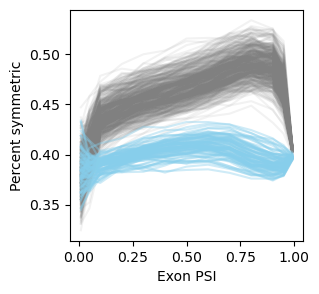

In [146]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))


for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.array(bins[:-1]), vals, c='gray', alpha=0.1)
        
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.array(bins[:-1]), vals, c='skyblue', alpha=0.4)
        
# ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

In [144]:
polyA_sym = psi.loc[impact.loc[impact.symmetric].index.intersection(psi.index)].mean(axis=1)
chRNA_sym = psi_chRNA.loc[impact.loc[impact.symmetric].index.intersection(psi_chRNA.index)].mean(axis=1)

Text(0.5, 1.0, 'Poison exon')

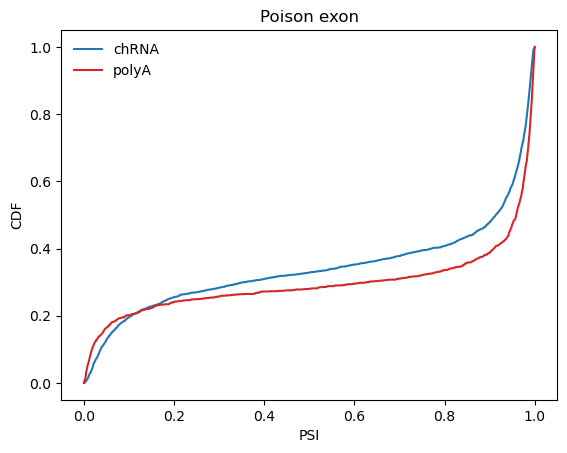

In [145]:
x = np.linspace(0, 1, 1001)
plt.plot(x, [(chRNA_sym <= i).mean() for i in x], c='tab:blue', label='chRNA')
plt.plot(x, [(polyA_sym <= i).mean() for i in x], c='tab:red', label='polyA')
plt.legend(frameon=False)
plt.xlabel('PSI')
plt.ylabel('CDF')
plt.title('Poison exon')